In [1]:
# getting started - easier

import numpy as np
from time import perf_counter, sleep
import matplotlib.pyplot as plt
from tqdm import tqdm

from board import board_obj
from operations import ops
import vis_tools

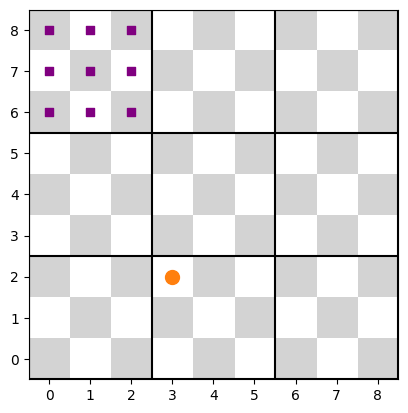

In [2]:
# initialize a board, a container that holds the game information
some_board = board_obj()

# perform an operation on the board, specifically making a move at (3,2)
ops.make_move(some_board, (3,2))

# visualize
vis_tools.fancy_draw_board(some_board)
vis_tools.add_valid_moves(some_board)

---
## The engine, briefly

The "board object" contains static information, including game history.<br>
"Operations" are applied to update that board based on agent requests.

You will have access to the operations library which may simplify your design. This was recently rewritten to include 'move' and 'undo' functions that should help with tree searches.

---
## Build a bot

You need to build a bot. This will be a python class with some required functions.<br>
You will have access to the following libraries: 
- xyz
- abc
- hij

---
Below is an example bot:

In [3]:
class template_bot:
    '''
    this bot selects a random valid move
    '''
    def __init__(self, name = 'beep-boop'):
        self.name = name
    def move(self, board_dict):
        random_index = np.random.choice(len(board_dict['valid_moves']))
        return board_dict['valid_moves'][random_index]

All bots will have a "move" method that takes a dictionary as input.<br>
Let's take a look at that dictionary using the "ops" library:

In [4]:
ops.pull_dictionary(some_board)

{'board_state': array([[-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -1., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0.]]),
 'active_box': (0, 2),
 'valid_moves': [(0, 6),
  (0, 7),
  (0, 8),
  (1, 6),
  (1, 7),
  (1, 8),
  (2, 6),
  (2, 7),
  (2, 8)],
 'history': array([[3, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 

There are 3 keys:<br>
- The "board_state" is are the locations of each placed marker. Your markers are +1, your opponent is -1.
- The "active_box" identifies which miniboard the current player plays on.
- "valid_moves" is a list of the valid positions that can be returned.


In [63]:
''' core imports '''
import numpy as np
import matplotlib.pyplot as plt
import queue
from bigtree import Node

''' development imports'''
from time import perf_counter
from tqdm import tqdm

''' visualization imports '''
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['lightgrey', 'white'])
import matplotlib.colors as mcolors
tab10_names = list(mcolors.TABLEAU_COLORS) # create a list of colours


# author: Aidan
# date: Nov 28 2023
# notes: Using line_completer.py as the baseline then added my own stuff in
# will look into using a tree search
# https://michaelxing.com/UltimateTTT/v3/ai/ bot seems to try and get two in a row for squares it is tring to get
# for squares it is not trying to get it puts them in bad squares to stop me from getting the square while also trying
# to land me in a bad sqaure to play in. 
# the AI seems to think the middle square in the middle is the best first move
# The best response to that is to put the other player into the corner square
# appears to be a good strategy to not repeat squares until you have to as it can allow the oponent to get two in a row
# dont make a move that will result in oponent putting you right back where you were when you dont want to be there
# all about wanting oponent to make forcing moves. Or a good move for them results in a better move for you
# maybe make a bot that tries to make a move that forces the opponent to make a move that is bad for them rather
# than making a move that is good for you
# the 9 major squares some or more valuable then others. Winning those squares is a priority
# The squares are ranked at start and can change based on game state

class BotKiller:
    #BotKiller
    MPQueue = queue.PriorityQueue() #put values in negative to get max
    root = Node
    #key is value given and the actual value is the move
    ''' ------------------ required function ---------------- '''
    
    def __init__(self,name: str = 'Chekhov') -> None:
        self.name = name
        # define the probability distribution
        self.box_probs = np.ones((3,3)) # edges
        self.box_probs[1,1] = 4 # center
        self.box_probs[0,0] = self.box_probs[0,2] = self.box_probs[2,0] = self.box_probs[2,2] = 2 # corners
        self.MajorSquareRank = np.array([[2,1,2],[1,3,1],[2,1,2]])#middle most valuable, then corners then edges
        self.InitialMajorSquareRank = np.array([[2,1,2],[1,3,1],[2,1,2]])#middle most valuable, then corners then edges
        #because 4 moves are made before start may be worth anaylizing the board and changing the rank of the squares
        self.GameState = np.zeros((3,3))#State of major boxes. (i.e. the total game state of the board)
    
    def move(self, board_dict: dict) -> tuple:
        ''' wrapper
        apply the logic and returns the desired move
        The tuple being returned is in reference to the 81 squares, so it could be anything from (0,0) to 
        (8,8) - x column then y row. This avoids ambiguity when a player can play in multiple miniboards 
        (such as when their opponent sends them to a completed miniboard).
        '''
        
        return tuple(self.ChooseBestMajorSquare(board_state = board_dict['board_state'],
                                                  active_box = board_dict['active_box'],
                                                  valid_moves = board_dict['valid_moves']))
    ''' --------- generally useful bot functions ------------ '''
    
    def _check_line(self, box: np.array) -> bool:
        '''
        box is a (3,3) array
        returns True if a line is found, else returns False '''
        for i in range(3):
            if abs(sum(box[:,i])) == 3: return True # horizontal
            if abs(sum(box[i,:])) == 3: return True # vertical

        # diagonals
        if abs(box.trace()) == 3: return True
        if abs(np.rot90(box).trace()) == 3: return True
        return False

    def _check_line_playerwise(self, box: np.array, player: int = None):
        ''' returns true if the given player has a line in the box, else false
        if no player is given, it checks for whether any player has a line in the box'''
        if player == None:
            return self._check_line(box)
        if player == -1:
            box = box * -1
        box = np.clip(box,0,1)
        return self._check_line(box)
    
    def pull_mini_board(self, board_state: np.array, mini_board_index: tuple) -> np.array:
        ''' extracts a mini board from the 9x9 given its index'''
        temp = board_state[mini_board_index[0]*3:(mini_board_index[0]+1)*3,
                           mini_board_index[1]*3:(mini_board_index[1]+1)*3]
        return temp

    def get_valid(self, mini_board: np.array) -> np.array:
        ''' gets valid moves in the miniboard'''
        return np.where(mini_board == 0)

    def get_finished(self, board_state: np.array) -> np.array:
        ''' calculates the completed boxes'''
        opp_boxes = np.zeros((3,3))
        self_boxes = np.zeros((3,3))
        stale_boxes = np.zeros((3,3))
        # look at each miniboard separately
        for _r in range(3):
            for _c in range(3):
                mini_board = self.pull_mini_board(board_state, (_r,_c))
                self_boxes[_r,_c] = self._check_line_playerwise(mini_board, player = 1)
                opp_boxes[_r,_c] = self._check_line_playerwise(mini_board, player = -1)
                if sum(abs(mini_board.flatten())) == 9:
                    stale_boxes[_r,_c] = 1                   

        # return finished boxes (separated by their content)
        return (opp_boxes*-1, self_boxes, stale_boxes)
    
    def get_num_finished(self, board_state: np.array):
        ''' returns a list of the number of finished boxes for each player'''
        Boxes = [0,0,0]
        for r in range(3):
            for c in range(3):
                if(board_state[r,c] == 1):
                    Boxes[0]+=1
                elif(board_state[r,c] == -1):
                    Boxes[1]+=1
                else:
                    Boxes[2]+=1
        return Boxes

    def complete_line(self, mini_board: np.array) -> list:
        ''' completes a line if available '''
        # loop through valid moves with hypothetic self position there.
        # if it makes a line it's an imminent win
        imminent = list()
        valid_moves = self.get_valid(mini_board)
        
        for _valid in zip(*valid_moves):
            # create temp valid pattern
            valid_filter = np.zeros((3,3))
            valid_filter[_valid[0],_valid[1]] = 1
            if self._check_line(mini_board + valid_filter):
                imminent.append(_valid)
        return imminent
    
    def get_probs(self, valid_moves: list) -> np.array:
        ''' match the probability with the valid moves to weight the random choice '''
        probs = list()
        for _valid in valid_moves:
            probs.append(self.box_probs[_valid[0],_valid[1]])
        probs /= sum(probs) # normalize
        return probs
    
    ''' ------------------ bot specific logic ---------------- '''
    
    def ChooseBestMajorSquare (self, board_state: np.array, active_box: tuple, valid_moves: list):
        ''' chooses the best major square to play in based on the current board state'''
        # if the active box is not the whole board
        #print(valid_moves)
        #print("Active box:",active_box)
        if active_box != (-1,-1):
            # look just at the mini board
            #print("MiniBoard")
            #print(board_state.shape)
            #print("Active Box:",active_box)
            mini_board = self.pull_mini_board(board_state, active_box)
            # look using the logic, select a move
            #print("Before move miniboard:",mini_board)
            move = self.ChooseBestMiniSquare(mini_board,valid_moves,active_box,board_state)
            #print("after move:", move)
            #print("active box:", active_box)
            #print("adding move and active", move[0] + 3 * active_box[0])
            # project back to original board space
            Best_Move = (move[0] + 3 * active_box[0],
                    move[1] + 3 * active_box[1])
            #print("mini board:",mini_board)
            #print("valid moves:",valid_moves)
            #print("best move is:",Best_Move)
            return (move[0] + 3 * active_box[0],
                    move[1] + 3 * active_box[1])

        else:
            # use heuristic on finished boxes to select which box to play in
            imposed_active_box = self.CalculateBoardState(board_state)

            # call this function with the self-imposed active box
            return self.ChooseBestMajorSquare(board_state = board_state,
                                                active_box = imposed_active_box,
                                                valid_moves = valid_moves)
        
    def CalculateBoardState(self, board_state: np.array):
        ''' calculates the current state of the board for Major Square Heuristic'''
        best_case = [1,1]
        HighestRank = -90
        #print("board state:",board_state)
        for i in range(3):
            for j in range(3):
                self.GameState[i,j] = self.CalculateMiniBoardState(self.pull_mini_board(board_state, (i,j)))
                '''if (self.GameState[i,j] == 1):
                    self.MajorSquareRank[i,j] = 1
                elif(self.GameState[i,j] == -1):
                    self.MajorSquareRank[i,j] = -1
                elif(self.GameState[i,j] == 0):
                    self.MajorSquareRank[i,j] = 0
                else:
                    self.MajorSquareRank[i,j]+=self.GameState[i,j]#need to test this. See if its any good'''
                    #or do the following instead. GameState is for board state, MSR is for value of major squares
                if (self.GameState[i,j] == 2 or self.GameState[i,j] == -2 or self.GameState[i,j] == 0):
                    #If a Major square is won, lost or stalemate then it is worth 0
                    self.MajorSquareRank[i,j] = -100
                else:
                    #If a Major square is not won, lost or stalemate then it is worth the value of the mini squares * InitialMajorSquareRank
                    self.MajorSquareRank[i,j] = self.GameState[i,j]*self.InitialMajorSquareRank[i,j]
                    if(self.MajorSquareRank[i,j]>HighestRank):
                        HighestRank = self.MajorSquareRank[i,j]
                        best_case = [i,j]
                        #print("HR: i,j:",i,j)
                        #print("Highets Rank:",HighestRank)
        
        return tuple(best_case)
        

    def CalculateMiniBoardState(self, mini_board: np.array):
        ''' calculates the current state of the mini board for ChooseBestMiniSquare'''
        #if the board is won return 2
        if self._check_line_playerwise(mini_board, player = 1):
            return 2
        #if the board is lost return -2
        if self._check_line_playerwise(mini_board, player = -1):
            return -2
        #if the board has more opponent moves in it return -1
        get_finished = self.get_num_finished(mini_board)
        #[0] is self, [1] is opponent, [2] is stale
        if get_finished[1]>get_finished[0]:
            return -1
        #if the board has more self moves in it return 1
        if(get_finished[1]<get_finished[0]):
            return 1
        #if the board is a stalemate return 0
        if(get_finished[2] == 9):
            return 0
        #if the board has same amount of opponent moves as self moves return 0.5
        return 0.5
        

    def EnemyWinMove(self, mini_board: np.array):
        ''' checks if the enemy has a winning move in the mini board'''
        for i in range(3):
            for j in range(3):
                temp_board = mini_board.copy()
                temp_board[i,j] = -1
                if self._check_line_playerwise(temp_board, player = -1):
                    return True
            return False

    def CalculateMiniBoardStateEnemy(self, mini_board: np.array):
        ''' calculates the current state of the mini board for ChooseBestMiniSquare'''
        if(self.EnemyWinMove(mini_board)):
            return -2
        get_finished = self.get_num_finished(mini_board)
        if(get_finished[2] == 9 or self._check_line_playerwise(mini_board, player = 1) or self._check_line_playerwise(mini_board, player = -1)):
            return -2
        else:
            return 0
        
        
        #if the board is won return 1
        if self._check_line_playerwise(mini_board, player = -1):
            return 2
        #if the board is lost return -1
        if self._check_line_playerwise(mini_board, player = 1):
            return -2
        #if the board has more opponent moves in it return -0.5
        get_finished = self.get_num_finished(mini_board)
        #[0] is self, [1] is opponent, [2] is stale
        if get_finished[1]>get_finished[0]:
            return -1
        #if the board has more self moves in it return 0.5
        if(get_finished[1]<get_finished[0]):
            return 1
        #if the board is a stalemate return 0
        if(get_finished[2] == 9):
            return 0
        #if the board has same amount of opponent moves as self moves return 0.1
        return 0.5


    def MoveOutcome(self, board_state: np.array, move: tuple,active_box: tuple):
        ''' calculates the outcome of a move'''
        temp_board_state = board_state.copy()
        temp_board_state[move[0] + 3 * active_box[0],move[1] + 3 * active_box[1]] = 1
        temp_board = self.pull_mini_board(temp_board_state, move)

        return self.CalculateMiniBoardStateEnemy(temp_board)


    def ChooseBestMiniSquare (self, miniBoard: np.array,valid_moves,active_box,board_state):
        #look through the mini board and find the best square to play in based on what it does for me.
        #first check if can make a move that wins me a Major square. Then if it does check to see if winning
        #that square is valuable or not using CalculateMiniBoardState. If it is valuable play there. If not put in MP Queue
        #then check other possible moves and see what major square it puts them into. Check the value of those squares
        #using CalculateMiniBoardState. If it is valuable dont play there. Want to play a move that puts the opponent
        #in a bad major square. For each, put into the MPQueue. Once all moves are checked, take the move with the
        #highest value from the MPQueue and play it. 
        #print("miniBoard:",miniBoard)
        #print("miniBoard:",miniBoard)
        for i in range(3):
                for j in range (3):
                    #print("MB:",miniBoard)
                    if miniBoard[i,j] == 0:
                        #print("i,j:",i,j)
                        #print("MB[ij]:",miniBoard[i,j])
                        temp_board = miniBoard.copy()
                        temp_board[i,j] = 1
                        #print("miniBoard:",miniBoard)
                        #print("temp_board:",temp_board)
                        MiniBoardState = self.CalculateMiniBoardState(temp_board)
                        MiniBoardState+=self.MoveOutcome(board_state, (i,j),active_box)
                        #print("MiniBoardState:",MiniBoardState)
                        self.MPQueue.put((-MiniBoardState, (i,j)))#put in negative to get max
                        #check if it wins me a major square
                        #if it does, check if that square is valuable
                        #if it is, play there
                        #if not, put in MPQueue
                        #check other possible moves and see what major square it puts them into
                        #check the value of those squares
                        #if it is valuable dont play there
                        #want to play a move that puts the opponent in a bad major square
                        #for each, put into the MPQueue
                        #once all moves are checked, take the move with the highest value from the MPQueue and play it
                    
        #return the move with the highest value from the MPQueue
        Best_Move = [0,0]
        if(self.MPQueue.empty()):
            #print("MPQueue is empty")
            Best_Move[0] = valid_moves[0][0] - 3 * active_box[0]
            Best_Move[1] = valid_moves[0][1] - 3 * active_box[1]
        else:
            #print("MPQueue:",self.MPQueue.queue)
            Best_Move = self.MPQueue.get()[1]
            #print("bestMove:",Best_Move)
            #print("valid moves:",valid_moves)
            self.MPQueue = queue.PriorityQueue()
        return Best_Move



In [101]:
''' define bots '''
agent1 = BotKiller()
agent2 = template_bot()

''' track time to calculate turn '''
agent1_times = list()
agent2_times = list()

win_counter = 0 # quick integer check to see whether line bot wins more than loses

for game_index in tqdm(range(100)):
    my_board = board_obj()
    for i in range(81): # up to 81 moves per game.
        ''' ------ agent 1 turn ------'''
        # get dictionary 
        temp_dict = ops.pull_dictionary(my_board)
        # give dict to agent, calculate move
        start = perf_counter()
        agent1_move = agent1.move(temp_dict)
        agent1_times.append(perf_counter()-start)
        # validate the move
        if not ops.check_move_is_valid(my_board, agent1_move):
            raise Exception(f'invalid move selected by p1, {agent1_move}')

        # make the move
        ops.make_move(my_board, agent1_move)
        # check whether game is finished
        if ops.check_game_finished(my_board):
            win_counter += 1
            break

        ''' agent 2 turn '''
        # get dictionary 
        temp_dict = ops.pull_dictionary(my_board)
        # give dict to agent, calculate move
        start = perf_counter()
        agent2_move = agent2.move(temp_dict)
        agent2_times.append(perf_counter()-start)

        # validate the move
        if not ops.check_move_is_valid(my_board, agent2_move):
            raise Exception(f'invalid move selected by p2, {agent2_move}')
        # make the move
        ops.make_move(my_board, agent2_move)
        # check whether game is finished
        if ops.check_game_finished(my_board):
            win_counter -= 1
            break

print(win_counter)

100%|██████████| 100/100 [00:05<00:00, 19.85it/s]

62


---
## Debugging
Inevitably you'll run into errors.<br>
You can narrow down the source of the error by investigating the state of the board and the action your bot wants to make.
Pull the information about the board with:

In [7]:
print('agent1 move:', agent1_move, '\n')

print('valid moves:', ops.get_valid_moves(my_board), '\n')

print('dict:',ops.pull_dictionary(my_board), '\n')


agent1 move: (6, 5) 

valid moves: [(3, 8), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 2), (7, 1), (7, 2), (8, 0), (8, 2)] 

dict: {'board_state': array([[ 1.,  0.,  0., -1., -1.,  1., -1., -1.,  0.],
       [-1., -1.,  0.,  1., -1., -1., -1., -1.,  0.],
       [-1., -1., -1.,  0., -1., -1.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0., -1., -1.,  1.,  1., -1.,  1.,  0.,  0.],
       [-1., -1., -1.,  0., -1., -1.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]), 'active_box': (-1, -1), 'valid_moves': [(3, 8), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 2), (7, 1), (7, 2), (8, 0), (8, 2)], 'history': array([[0, 0],
       [2, 1],
       [6, 3],
       [2, 2],
       [6, 6],
       [1, 1],
       [3, 3],
       [1, 0],
       [3, 0],
       [2, 0],
       [6, 0],
       [2, 8],
       [6, 7],
       [2, 5],
       [7, 6],

And visualize the board with:

HR: i,j: 1 2
Highets Rank: 0
HR: i,j: 2 0
Highets Rank: 1
selected moved given this board: (7, 1)


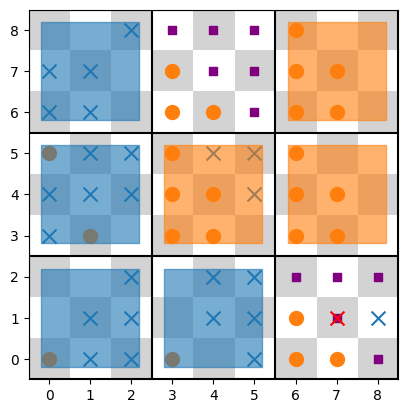

In [8]:
# visualize the game state
vis_tools.fancy_draw_board(my_board)
vis_tools.add_valid_moves(my_board)

# using this info, see what move your agent wants to make
selected_move = agent1.move(ops.pull_dictionary(my_board))
print('selected moved given this board:', selected_move)
plt.scatter(selected_move[0],selected_move[1],c='r',s=100,marker='x');

---
## Evaluation and timing
Once you get a bot up and running, take a look at how long you have to calculate moves with the "times" list.
The win_counter is a quick and dirty way to evaluate your bot against some opponent.


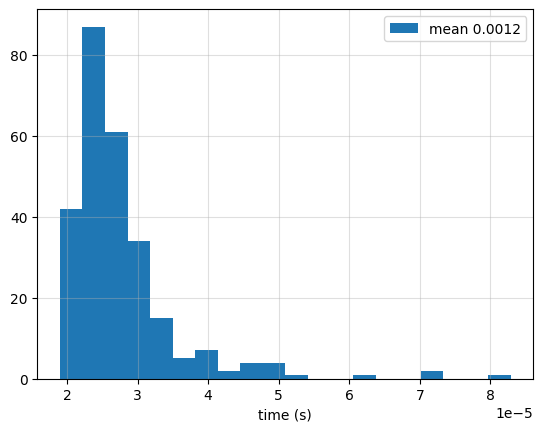

In [9]:

''' plot the times your bot took to execute a move '''
# the mean must be below 0.5 seconds

plt.hist(agent2_times,bins=20,label=f'mean {np.round(np.mean(agent1_times),4)}')
plt.xlabel('time (s)')
plt.grid(alpha=0.4)
plt.legend();


---
## Try to beat a decent bot


In [10]:
from line_completer import line_completer_bot

''' define bots '''
agent1 = line_completer_bot()
agent2 = your_bot()

''' track time to calculate turn '''
agent1_times = list()
agent2_times = list()

win_counter = 0 # quick integer check to see whether line bot wins more than loses

for game_index in tqdm(range(100)):
    my_board = board_obj()
    for i in range(81): # up to 81 moves per game.
        ''' ------ agent 1 turn ------'''
        # get dictionary 
        temp_dict = ops.pull_dictionary(my_board)
        # give dict to agent, calculate move
        start = perf_counter()
        agent1_move = agent1.move(temp_dict)
        agent1_times.append(perf_counter()-start)
        # validate the move
        if not ops.check_move_is_valid(my_board, agent1_move):
            raise Exception(f'invalid move selected by p1, {agent1_move}')

        # make the move
        ops.make_move(my_board, agent1_move)
        # check whether game is finished
        if ops.check_game_finished(my_board):
            win_counter += 1
            break

        ''' agent 2 turn '''
        # get dictionary 
        temp_dict = ops.pull_dictionary(my_board)
        # give dict to agent, calculate move
        start = perf_counter()
        agent2_move = agent2.move(temp_dict)
        agent2_times.append(perf_counter()-start)

        # validate the move
        if not ops.check_move_is_valid(my_board, agent2_move):
            raise Exception(f'invalid move selected by p2, {agent2_move}')
        # make the move
        ops.make_move(my_board, agent2_move)
        # check whether game is finished
        if ops.check_game_finished(my_board):
            win_counter -= 1
            break

print(win_counter)

NameError: name 'your_bot' is not defined